Regularized Abel Inversion
===================

This example demonstrates a TV-regularized Abel inversion using
an Abel projector based on PyAbel <cite data-cite="pyabel-2022"/>

In [1]:
import numpy as np

import jax

import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
x_gt = create_circular_phantom((256, 254), [100, 50, 25], [1, 0, 0.5])
x_gt = jax.device_put(x_gt)

Set up the forward operator and create a test measurement

In [3]:
A = AbelProjector(x_gt.shape)
y = A @ x_gt
y = y + 1 * np.random.normal(size=y.shape).astype(np.float32)
ATy = A.T @ y

Set up ADMM solver object.

In [4]:
λ = 1.71e01  # L1 norm regularization parameter
ρ = 4.83e01  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

g = λ * functional.L1Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape)

f = loss.SquaredL2Loss(y=y, A=A)

x_inv = A.inverse(y)
x0 = snp.clip(x_inv, 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.20e+00  2.929e+04  4.183e+01  8.589e+01     18  8.559e-05
   5  3.01e+00  4.598e+04  3.722e+00  2.500e+00      8  9.881e-05


  10  3.10e+00  4.810e+04  2.562e+00  9.662e-01      6  6.051e-05
  15  3.17e+00  4.927e+04  2.087e+00  2.292e-01      0  7.281e-05
  20  3.23e+00  5.011e+04  1.309e+00  1.809e-01      0  7.795e-05


  25  3.27e+00  5.087e+04  1.050e+00  1.150e-01      0  9.238e-05
  30  3.31e+00  5.122e+04  8.960e-01  1.059e-01      0  9.835e-05
  35  3.34e+00  5.138e+04  7.919e-01  9.458e-02      0  9.493e-05
  40  3.38e+00  5.156e+04  7.103e-01  7.929e-02      0  9.988e-05
  45  3.41e+00  5.235e+04  8.515e-01  6.641e-02      0  8.951e-05
  50  3.44e+00  5.210e+04  6.572e-01  1.772e-01      2  9.206e-05


  55  3.48e+00  5.203e+04  1.338e+00  1.148e+00      5  6.226e-05
  60  3.51e+00  5.213e+04  1.062e+00  1.269e-01      0  8.386e-05
  65  3.55e+00  5.235e+04  7.011e-01  5.448e-02      0  8.482e-05
  70  3.58e+00  5.238e+04  5.748e-01  4.566e-02      0  9.500e-05
  75  3.61e+00  5.240e+04  4.480e-01  9.864e-02      2  8.942e-05
  80  3.64e+00  5.268e+04  1.213e+00  8.757e-02      0  7.467e-05
  85  3.68e+00  5.276e+04  1.599e+00  4.994e-01      4  6.936e-05


  90  3.71e+00  5.249e+04  5.956e-01  4.732e-02      0  8.805e-05
  95  3.74e+00  5.261e+04  4.703e-01  2.611e-02      0  9.326e-05
  99  3.76e+00  5.263e+04  4.443e-01  3.498e-02      0  9.776e-05


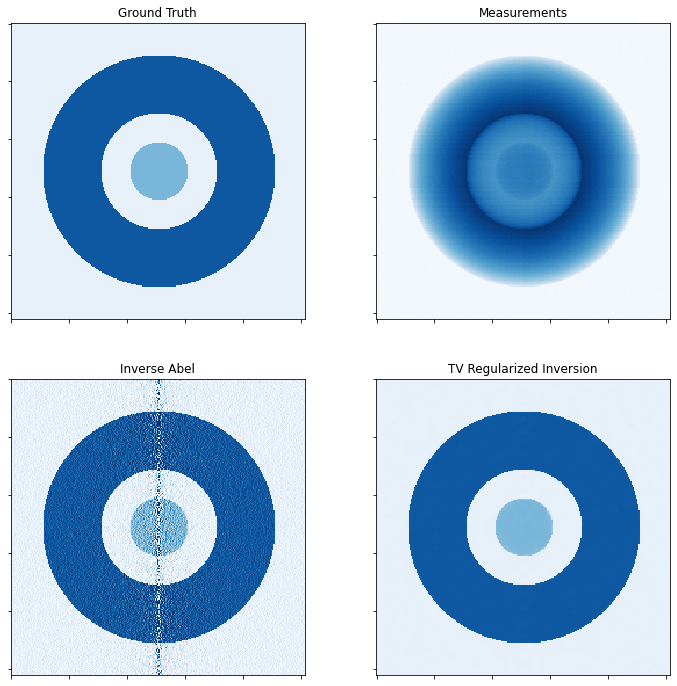

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0, 1.0)

norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurements", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(x_inv, title="Inverse Abel", cmap=plot.cm.Blues, fig=fig, ax=ax[1, 0], norm=norm)
plot.imview(
    x_tv, title="TV Regularized Inversion", cmap=plot.cm.Blues, fig=fig, ax=ax[1, 1], norm=norm
)
fig.show()